# Stellar Core Collapse Signal GAN training

This demonstrates our training  process for a Generative Adversarial Network (GAN) to generate stellar core collapse signals. The GAN is trained on a dataset of 1764 stellar core collapse signals, each with 256 timestamps.



In [ ]:
# critical
import argparse
import os
import random
import time
import math

# machine learning
from sklearn.decomposition import PCA

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.utils as vutils

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [ ]:
# set random seed for reproducibility
manualSeed = 99
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [ ]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
# num_epochs = int(32 * (6000/1684))
# num_epochs = 32
num_epochs = 128

# Learning rate for optimizers
lr_g = 0.00002
lr_d = 0.00002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# type of gan
gans_type = "dcgans"

### Dataloader

In [2]:
from staccato.training.training_data import TrainingData

training_data = TrainingData()
training_data.summary()

Signal Dataset mean: -0.5163595676422119 +/- 39.72416305541992
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset shape: (256, 1684)



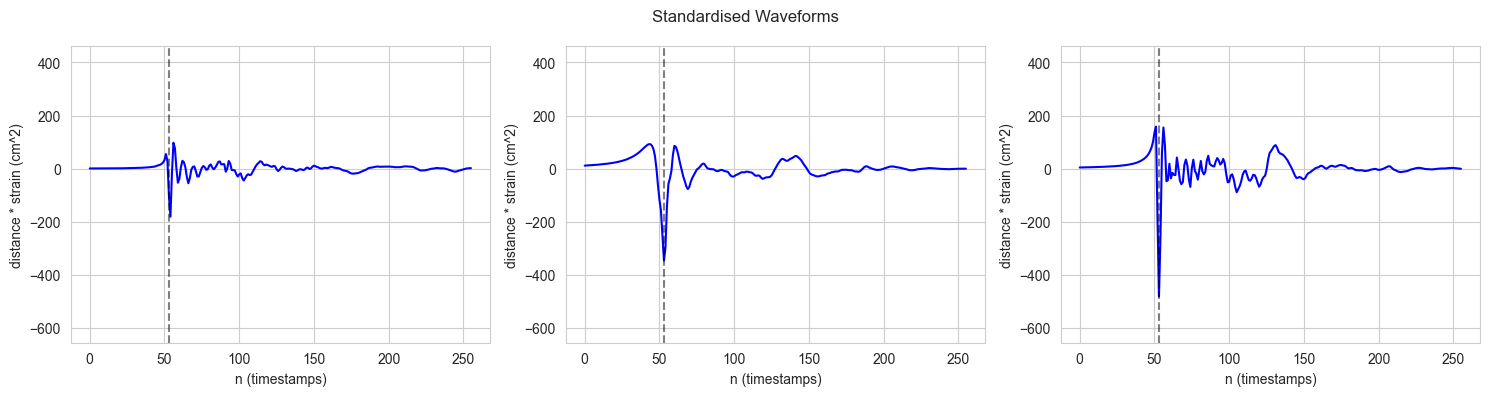

In [3]:
fig, axes = training_data.plot_waveforms(standardised=True)

### Weight Initialisation (Random Noise)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Generator

In [ ]:
if gans_type == 'dcgans':
    class Generator(nn.Module):
        def __init__(self):
            super().__init__()
            self.main = nn.Sequential(
                nn.ConvTranspose1d(nz, ngf * 32, kernel_size=4, stride=1, padding=0, bias=False),
                nn.BatchNorm1d(ngf * 32),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 32, ngf * 16, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 16),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 16, ngf * 8, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(True),

                nn.ConvTranspose1d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            )

        def forward(self, z):
            z = self.main(z)
            return z
        
if gans_type == 'gans':
    class Generator(nn.Module):
        def __init__(self):
            super(Generator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(nz, ngf),
                nn.BatchNorm1d(ngf),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf, ngf * 2),
                nn.BatchNorm1d(ngf * 2),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 2, ngf * 4),
                nn.BatchNorm1d(ngf * 4),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 4, ngf * 8),
                nn.BatchNorm1d(ngf * 8),
                nn.LeakyReLU(0.2, inplace=True),

                nn.Linear(ngf * 8, 512),
            )

        def forward(self, z):
            z = z.view(z.size(0), -1)  # Flatten the tensor
            z = self.main(z)
            z = z.view(z.size(0), 1, 512)
            return z

In [ ]:
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

model = Generator()
summary(model, input_size=(nz, nc))

### Discriminator

In [ ]:
if (gans_type == "dcgans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 8),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                ### Can increase model complexity here ###
                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc = nn.Sequential(
                nn.LazyLinear(1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            x = self.fc(x)
            return x

elif (gans_type == "gans"):
    class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(256, 128),
                # nn.BatchNorm1d(128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(128, 64),
                # nn.BatchNorm1d(64),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(64, 32),
                # nn.BatchNorm1d(32),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(32, 16),
                # nn.BatchNorm1d(16),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.2),

                nn.Linear(16, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = self.main(x)
            return x

In [ ]:
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

model = Discriminator()
summary(model, input_size=(nc, 256))

### Loss functions and Optimisers

In [ ]:
criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# learning-rate decay scheduler
schedulerD = lr_scheduler.LinearLR(optimizerD, start_factor=1.0, end_factor=0.5, total_iters=32)
schedulerG = lr_scheduler.LinearLR(optimizerG, start_factor=1.0, end_factor=0.5, total_iters=32)

# establish convention for real and fake labels during training
real_label = 1.0
fake_label = 0.0

In [ ]:
# create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, device=device)

num_cols = 4
num_rows = 4

# plot generated signals before training
with torch.no_grad():
    fake_signals = netG(fixed_noise).detach().cpu()
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    axes = axes.flatten()

    # plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = [i / 4096 for i in range(0, 256)]
        x = [value - (53/4096) for value in x]
        y = fake_signals[i, :, :].flatten()
        y = y * dataset.scaling_factor
        y = y * dataset.std + dataset.mean
        ax.set_ylim(-600, 300)
        ax.plot(x, y, color='red')

        ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax.grid(True)
        
        # Remove y-axis ticks for the right-hand column
        if i % num_cols == num_cols - 1:
            ax.yaxis.set_ticklabels([])
        
        # Remove x-axis tick labels for all but the bottom two plots
        if i <= 11:
            ax.xaxis.set_ticklabels([])

    for i in range(512, 8*4):
        fig.delaxes(axes[i])

    fig.supxlabel('time (s)', fontsize=24)
    fig.supylabel('distance x strain (cm)', fontsize=24)

    plt.tight_layout()
    plt.show()

### Training

In [ ]:
# Training Loop

# Lists to keep track of progress
signal_list = []
G_losses = []
D_losses = []
D_gradients = []
G_gradients = []
iters = 0

start = time.time()

if (gans_type == 'dcgans' or gans_type == 'gans'):
    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_gpu = data.to(device)
            b_size = real_gpu.size(0)
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # Forward pass real batch through D
            output = netD(real_gpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label_real)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, device=device)
            # Generate fake signal batch with G
            fake = netG(noise)
            label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.25).to(device)
            # label_fake = torch.FloatTensor(b_size).uniform_(0.0, 0.0).to(device)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label_fake)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()
            # Calculate gradients of discriminator parameters
            D_gradients.append([param.grad.norm().item() for param in netD.parameters()])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label_real = torch.FloatTensor(b_size).uniform_(1.0, 1.0).to(device)
            # label_real = 1.0 - label_fake
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label_real)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            # Calculate gradients of generator parameters
            G_gradients.append([param.grad.norm().item() for param in netG.parameters()])

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            iters += 1 
        
        # learning-rate decay
        before_lr = optimizerD.param_groups[0]["lr"]
        schedulerD.step()
        after_lr = optimizerD.param_groups[0]["lr"]
        print("Epoch %d: SGD Discriminator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        before_lr = optimizerG.param_groups[0]["lr"]
        schedulerG.step()
        after_lr = optimizerG.param_groups[0]["lr"]
        print("Epoch %d: SGD Generator lr %.7f -> %.7f" % (epoch, before_lr, after_lr))

        # plot generated signals before training
        with torch.no_grad():
            fake_signals = netG(fixed_noise).detach().cpu()
            fig, axes = plt.subplots(4, 4, figsize=(15, 12))

            axes = axes.flatten()

            # plot each signal on a separate subplot
            for i, ax in enumerate(axes):
                x = [i / 4096 for i in range(0, 256)]
                x = [value - (53/4096) for value in x]
                y = fake_signals[i, :, :].flatten()
                y = y * dataset.scaling_factor
                y = y * dataset.std + dataset.mean
                ax.set_ylim(-600, 300)
                ax.plot(x, y, color='red')

                ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
                ax.grid(True)
                
                # Remove y-axis ticks for the right-hand column
                if i % num_cols == num_cols - 1:
                    ax.yaxis.set_ticklabels([])
                
                # Remove x-axis tick labels for all but the bottom two plots
                if i <= 11:
                    ax.xaxis.set_ticklabels([])

            for i in range(512, 8*4):
                fig.delaxes(axes[i])

            fig.supxlabel('time (s)', fontsize=24)
            fig.supylabel('distance x strain (cm)', fontsize=24)

            plt.tight_layout()
            plt.show()
        
        signal_list.append(fake_signals)

end = time.time()

print("Training Time: ", end - start)

### Gradients

In [ ]:
# Get the total number of layers in the discriminator
D_gradients = np.array(D_gradients)
num_layers = D_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(D_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Discriminator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_d_gradients_status_quo_32e.png")
plt.show()

In [ ]:
# Get the total number of layers in the discriminator
G_gradients = np.array(G_gradients)
num_layers = G_gradients.shape[1]

# Plot the gradients over training epochs
plt.figure(figsize=(10, 6))
for i in range(num_layers):
    # Calculate alpha value based on layer index
    alpha = 1 - (i / num_layers)  # Higher layers are more transparent
    plt.plot(G_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(0, 0, 1, alpha))

plt.xlabel('Batches')
plt.ylabel('Gradient Magnitude')
plt.title('Generator Gradients')
plt.legend()
# plt.savefig("../plots/architecture/gw_g_gradients_status_quo_32e.png")
plt.show()

### Loss

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Discriminator Loss Convergence Point')
plt.xlabel("Batch", size=20)
plt.ylabel("Loss", size=20)
plt.ylim(0, 5)
plt.legend(fontsize=16)
# plt.savefig("../plots/architecture/dcgans_training_loss_128e.pdf")
plt.show()

### Save Generator

In [ ]:
torch.save(netG, "../models/stellar_core_collapse_signal_generator_dcgans.pt")